# **Learn RAG from Scratch using LLMs**

Welcome to the Learn RAG from Scratch playlist! This series is your ultimate guide to mastering Retrieval-Augmented Generation (RAG) with step-by-step tutorials and hands-on projects. Whether you're a beginner or looking to enhance your skills, this playlist covers everything you need to know to work effectively with RAG and Large Language Models (LLMs).

💻 Full Playlist link with Explaination: https://www.youtube.com/playlist?list=PLYIE4hvbWhsAKSZVAn5oX1k0oGQ6Mnf1d

🔍 What You'll Learn:

1. RAG Fundamentals: Understand what RAG is and why it’s crucial for improving LLMs.
2. Chunking Techniques: Learn how to split data effectively for better retrieval.
3. Retrieval Strategies: Explore similarity measures like cosine, Euclidean, and others for precise data retrieval.
4. Projects Across Domains: Build AI solutions for real-world applications, from customer support to domain-specific chatbots.
5. Hugging Face Integration: Use pre-trained LLMs from Hugging Face with RAG for seamless implementation.

💻 Hands-on projects include:

1. Chatbots with RAG & LLM
2. Context-aware AI applications
3. Domain-specific retrieval systems

This playlist is perfect for data scientists, developers, and AI enthusiasts eager to leverage the power of RAG with tools like Python, LangChain, and Hugging Face.

💻 Follow me on Instagram - https://www.instagram.com/freebirdscrew/

💻 Follow me on LinkedIn - https://www.linkedin.com/in/simranjeet97/

![](https://github.com/simranjeet97/Learn_RAG_from_Scratch_LLM/blob/main/RAG.png?raw=true)

## **BBC News Dataset - RAG First Project**
To build a project integrating RAG (Retrieval-Augmented Generation) and LLMs (Large Language Models) using the provided BBC news dataset, we’ll follow these steps:

**Project Overview:**

**Goal:** Create a system that retrieves relevant news articles based on user queries and generates contextual responses using an LLM (e.g., GPT-4 or Hugging Face models).

**Dataset:** The dataset contains descriptions and tags for BBC news articles. We’ll use the tags column for retrieval and the descr column for contextual data.

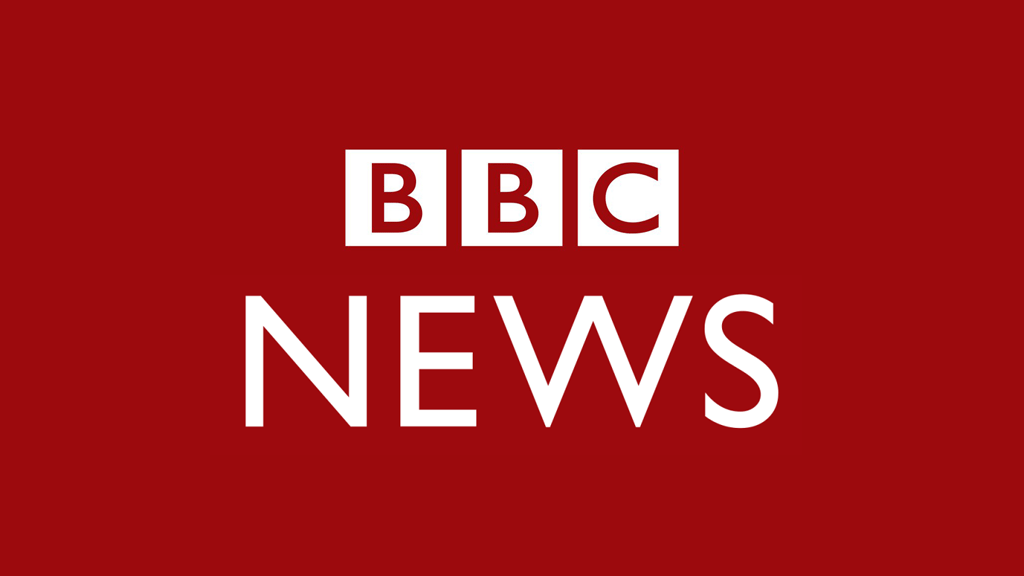

# **Data Ingestions**

In [ ]:
import pandas as pd

# Load the dataset
file_path = "BBCNews.csv"  # Replace with the actual path to the dataset
bbc_data = pd.read_csv(file_path)
bbc_data.columns = ['News_ID','Description','Tags']
# Display basic information
print(bbc_data.head())
print(bbc_data.info())

# Cleaning and preprocessing
bbc_data['Description'] = bbc_data['Description'].fillna('')  # Handle missing descriptions
bbc_data['Tags'] = bbc_data['Tags'].fillna('')  # Handle missing tags

### Preprocess the Dataset
Convert the descr and tags into documents that ChromaDB can store

In [ ]:
from langchain.docstore.document import Document

# Prepare documents for ChromaDB
documents = []
for _, row in bbc_data.iterrows():
    content = row['Description']
    tags = row['Tags']
    meta = {"tags": tags, "news_id": row['News_ID']}
    documents.append(Document(page_content=content, metadata=meta))

### Add Data into ChromaDB
Use ChromaDB to store the document embeddings for retrieval.

In [ ]:
from langchain.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings

hg_embeddings = HuggingFaceEmbeddings()

# Persist directory for ChromaDB
persist_directory = '/content/chroma_db/'

# Create ChromaDB from documents
langchain_chroma = Chroma.from_documents(
    documents=documents,
    collection_name="bbc_news",
    embedding=hg_embeddings,
    persist_directory=persist_directory
)

print("ChromaDB initialized and data persisted.")

# **Retrieval and Generation**

### Load the LLM
Load the LLM and load it in quantised format.

In [ ]:
from torch import cuda, bfloat16, float16
import transformers
from transformers import AutoTokenizer
from langchain.llms import HuggingFacePipeline
from time import time

model_id = 'HuggingFaceH4/zephyr-7b-beta'
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

# Configure model for efficient GPU memory usage
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=bfloat16
)

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map='auto',
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Initialize the query pipeline
query_pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=float16,
    max_new_tokens=500,
    device_map="auto",
)

llm = HuggingFacePipeline(pipeline=query_pipeline)

### Make the RAG Chain and Use RetrievalQA to build the Chain and get the Responses

In [ ]:
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

# Step 1: Define a custom prompt template for better guidance
custom_prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=(
        "You are an expert summarizer and analyst. Using the context provided, "
        "answer the question accurately and concisely. Context: {context}\n\n"
        "Question: {question}\nAnswer:"
    )
)

# Step 2: Create the retriever with optimized parameters
retriever = langchain_chroma.as_retriever(search_kwargs={"k": 3})

# Step 3: Build an enhanced RAG chain
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    return_source_documents=True,  # To get source documents along with the response
    chain_type_kwargs={"prompt": custom_prompt},  # Use the custom prompt
)

# Step 4: Query the RAG model
query = "What does the dataset say about sports news?"
result = qa_chain.invoke(query)

# Step 5: Print the response and sources for traceability
response = result["result"]
sources = result["source_documents"]

print(f"Query: {query}")
print(f"Response: {response}\n")

print("Sources:")
for idx, doc in enumerate(sources, 1):
    print(f"{idx}. {doc.metadata.get('tags', 'No Tags')} - {doc.page_content[:200]}...")

# **Smaller Chunks vs Larger Chunks**

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings

# Sample document (larger for better testing)
document = """
Elon Musk is the CEO of Tesla. Tesla's mission is to accelerate the world's transition to sustainable energy.
Tesla manufactures electric vehicles (EVs), battery energy storage, solar panels, and related products. SpaceX, another company led by Musk,
aims to make space travel accessible to humanity by developing reusable rockets.
Musk has also co-founded Neuralink, which focuses on connecting the human brain to computers using advanced neural interfaces.
Recently, Musk has expressed his concerns about artificial intelligence, advocating for regulation to prevent potential harm.
Musk believes that governments should play an active role in ensuring the safe development of AI technologies.
His innovative ventures span automotive, space exploration, energy, AI, and neuroscience, making him a pivotal figure in modern technology.
"""

# Small chunk size
small_splitter = RecursiveCharacterTextSplitter(chunk_size=20, chunk_overlap=2)
small_chunks = small_splitter.split_text(document)
print("Smaller Chunks -")
print(small_chunks)
# Large chunk size
large_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=10)
large_chunks = large_splitter.split_text(document)
print("Larger Chunks -")
print(large_chunks)
# Initialize embedding model
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Create vector stores
small_vector_store = Chroma.from_texts(small_chunks, embedding_model)
large_vector_store = Chroma.from_texts(large_chunks, embedding_model)

# Semantic query
query = "What are Musk's views on artificial intelligence and government regulations?"

# Perform search
small_results = small_vector_store.similarity_search(query, k=1)
large_results = large_vector_store.similarity_search(query, k=1)

# Display results
print("-----------------------------------")
print("Results")
print("-----------------------------------")
print("Small Chunk Results:", small_results)
print("Large Chunk Results:", large_results)

# **Chunking Strategies**

In Retrieval-Augmented Generation (RAG), chunking refers to the process of dividing a large corpus of text into smaller, more manageable units (chunks), which can be used for efficient retrieval and processing. The primary goal of chunking is to break down text into smaller pieces that maintain meaningful content while reducing computational complexity during retrieval.

1. Fixed Size Chunkng
2. Sentence Based Chunking
3. Document Based Chunking
4. Semantic Chunking
5. Overalapping Chunking
6. Recursive Chunking
7. Agentic Chunking
8. Content-Aware Chunking
9. Token Based Chunking
10. Topic Based Chunking
11. Keyword Based Chunking

### **1. Fixed-size Chunking (Sliding Window)**

**What It Is:**

Fixed-size chunking divides the text into fixed-length pieces or windows. This is done by splitting the text into chunks of a predetermined size (e.g., 512 tokens). This strategy is simple but can be inefficient for longer texts, especially if chunks cut across meaningful sections (like sentences).

**Use Case:**

Best for datasets where text length is fairly uniform or where processing uniform chunks is necessary.

In [ ]:
# Example of Fixed-size chunking using a sliding window

def fixed_size_chunk(text, chunk_size=512):
    # Split text into words and chunk them into fixed-size parts
    words = text.split()
    chunks = [words[i:i + chunk_size] for i in range(0, len(words), chunk_size)]
    return [' '.join(chunk) for chunk in chunks]

# Example text (typically a long document)
text = "This is a very long text that should be chunked into smaller pieces for efficient processing."

# Chunk into 5 words per chunk
chunks = fixed_size_chunk(text, chunk_size=5)

# Display the chunks
for i, chunk in enumerate(chunks):
    print(f"Chunk {i + 1}: {chunk}")

### **2. Sentence-based Chunking**

**What It Is:**

Sentence-based chunking divides the text into individual sentences, treating each as a chunk. This is useful when working with structured text or datasets where each sentence contains meaningful information and needs to be processed independently.

**Use Case:**

Ideal for processing formal documents (e.g., research papers, news articles) where individual sentences convey significant meaning.

In [ ]:
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt_tab')

# Example text (typically a paragraph)
text = "This is a sentence. Here is another one. And a third one."

# Chunk text into sentences
chunks = sent_tokenize(text)

# Display the chunks
for i, chunk in enumerate(chunks):
    print(f"Sentence {i + 1}: {chunk}")

## **3. Document-based Chunking**

**What It Is:**

Document-based chunking involves treating each document or major section of text as a chunk. This approach is used when the corpus consists of multiple documents that need to be retrieved independently.

**Use Case:**

Useful when the corpus is already organized into meaningful documents, such as articles, reports, or books.
LlamaIndex (formerly GPT Index) has a built-in feature that can identify document boundaries.

In [ ]:
from langchain.document_loaders import PyPDFLoader

pdf_loader = PyPDFLoader("sample.pdf")

# Load the PDF into documents
documents = pdf_loader.load()

# Display the documents to check their structure
for i, doc in enumerate(documents[:3]):  # Display first 3 chunks for preview
    print(f"Document {i + 1} Content:")
    print(doc.page_content[:500])  # Preview first 500 characters
    print("\n")

## **4. Semantic-based Chunking (Dynamic Chunking)**

**What It Is:**

Semantic-based chunking involves splitting text into chunks based on the meaning of the content rather than fixed length or sentence boundaries. The idea is to group related information, which may vary in length, into semantic units. This is often done using NLP techniques, such as sentence embeddings or document clustering, to identify the most relevant sections for each chunk.

**Use Case:**

Best for use in situations where meaningful semantic units (e.g., paragraphs, topics) should be grouped together regardless of the chunk size. This is useful for document summarization, knowledge extraction, and other advanced NLP tasks.

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np

# Initialize a model for sentence embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

# Example text (to simulate chunking)
sentences = [
    "Astronauts are sent to space.",
    "The Martian is about survival on Mars.",
    "Interstellar deals with space exploration.",
    "Space travel involves many challenges."
]

# Create embeddings for each sentence
embeddings = model.encode(sentences)

# Use clustering to group semantically similar sentences
kmeans = KMeans(n_clusters=2, random_state=0)
labels = kmeans.fit_predict(embeddings)

# Group sentences by their cluster label
chunks = {}
for i, label in enumerate(labels):
    if label not in chunks:
        chunks[label] = []
    chunks[label].append(sentences[i])

# Display semantic chunks
for label, chunk in chunks.items():
    print(f"Semantic Chunk {label + 1}: {', '.join(chunk)}")

## **5. Overlapping Chunking**

**What It Is:**

Overlapping chunking involves creating chunks that overlap with each other. For example, one chunk might contain the last few words of the previous chunk. This strategy is used to preserve context between chunks and ensure that no information is lost when dividing long texts.

**Use Case:**

Useful when context between sentences is important, such as for tasks like machine translation, summarization, or question-answering where the meaning of adjacent chunks is highly dependent on each other.

In [ ]:
def overlapping_chunk(text, chunk_size=5, overlap=2):
    words = text.split()
    chunks = []
    for i in range(0, len(words), chunk_size - overlap):
        chunk = words[i:i + chunk_size]
        chunks.append(' '.join(chunk))
    return chunks

# Example text
text = "This is an example of overlapping chunking to maintain context between chunks."

# Chunk into overlapping pieces with 5 words per chunk and 2-word overlap
chunks = overlapping_chunk(text, chunk_size=5, overlap=2)

# Display the chunks
for i, chunk in enumerate(chunks):
    print(f"Chunk {i + 1}: {chunk}")

## **6. Recursive Chunking**

Recursive chunking divides text in a hierarchical, iterative manner using a set of separators (such as newline characters or spaces). This method allows for more structured chunking based on content boundaries.

**Explanation:**

The method works by recursively splitting text into smaller chunks by examining separators like \n\n, \n, and spaces.
LangChain offers the RecursiveCharacterTextSplitter class, which allows the specification of separators to control how the text is split.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Sample text
text = """This is a paragraph \n. This is another paragraph. This is a new paragraph.

Here is some additional content.\n"""

# Initialize the RecursiveCharacterTextSplitter with separators
splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " "],
    chunk_size=50,  # Adjust chunk size as necessary
    chunk_overlap=10  # Optional: overlap chunks for context preservation
)

# Split the text
chunks = splitter.split_text(text)

# Display chunks
for i, chunk in enumerate(chunks):
    print(f"Chunk {i + 1}: {chunk}")

## **7. Agentic Chunking**

Agentic chunking leverages large language models (LLMs) to determine how to chunk the text based on its context. This is a more dynamic approach where the model itself decides how much and what part of the text should form a chunk.

**Explanation:**

The LLM is tasked with understanding the context of the text and then creating chunks based on the relevance of the information.
This technique uses the model's understanding of the content to ensure that chunks are informative and relevant.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("t5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("t5-base")

def chunk_text(text, max_length=512, stride=256):
    """Chunks text into smaller pieces based on token length and stride.

    Args:
        text (str): The input text.
        max_length (int, optional): Maximum token length of each chunk. Defaults to 512.
        stride (int, optional): Overlap between chunks. Defaults to 256.

    Returns:
        list: A list of text chunks.
    """

    input_ids = tokenizer(text, return_tensors="pt").input_ids[0]

    chunks = []
    i = 0
    while i < len(input_ids):
        end_idx = min(i + max_length, len(input_ids))
        chunk_ids = input_ids[i:end_idx]
        chunks.append(tokenizer.decode(chunk_ids, skip_special_tokens=True))
        i += stride

    return chunks

# Example usage
text = "Astronauts travel through space. The journey is difficult. Exploration of Mars is a recent milestone in space science."
chunks = chunk_text(text)

for chunk in chunks:
  print(chunk)

## **8. Content-Aware Chunking**

This method adapts chunking based on content characteristics (e.g., chunking text at paragraph level, tables as separate entities).

**When to Use:**

For documents with heterogeneous content, such as eBooks or technical manuals, chunking must vary based on content type.

In [ ]:
sample_text = """
Introduction

Data Science is an interdisciplinary field that uses scientific methods, processes,
 algorithms, and systems to extract knowledge and insights from structured and
 unstructured data. It draws from statistics, computer science, machine learning,
 and various data analysis techniques to discover patterns, make predictions, and
 derive actionable insights.

Data Science can be applied across many industries, including healthcare, finance,
 marketing, and education, where it helps organizations make data-driven decisions,
  optimize processes, and understand customer behaviors.

Overview of Big Data

Big data refers to large, diverse sets of information that grow at ever-increasing
rates. It encompasses the volume of information, the velocity or speed at which it
is created and collected, and the variety or scope of the data points being
covered.

Data Science Methods

There are several important methods used in Data Science:

1. Regression Analysis
2. Classification
3. Clustering
4. Neural Networks

Challenges in Data Science

- Data Quality: Poor data quality can lead to incorrect conclusions.
- Data Privacy: Ensuring the privacy of sensitive information.
- Scalability: Handling massive datasets efficiently.

Conclusion

Data Science continues to be a driving force in many industries, offering insights
that can lead to better decisions and optimized outcomes. It remains an evolving
field that incorporates the latest technological advancements.
"""


def content_aware_chunk(text):
    chunks = []
    current_chunk = []
    for line in text.splitlines():
        if line.startswith(('##', '###', 'Introduction', 'Conclusion')):
            if current_chunk:
                chunks.append('\n'.join(current_chunk))
            current_chunk = [line]
        else:
            current_chunk.append(line)
    if current_chunk:
        chunks.append('\n'.join(current_chunk))
    return chunks

# Applying Content-Aware Chunking
content_chunks = content_aware_chunk(sample_text)
for chunk in content_chunks:
    print(chunk, '\n---\n')

## **9. Token-Based Chunking**

Token-based chunking splits text based on a fixed number of tokens rather than words or sentences. It uses tokenizers from NLP models (e.g., Hugging Face’s transformers).

**When to Use:**

For models that operate on tokens, such as transformer-based models with token limits (e.g., GPT-3 or GPT-4).

Advantages:
- Works well with transformer-based models.
- Ensures token limits are respected.

Disadvantages:
- Tokenization may split sentences or break context.
- Not always aligned with natural language boundaries.


In [ ]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

def token_based_chunk(text, max_tokens=200):
    tokens = tokenizer(text)["input_ids"]
    chunks = [tokens[i:i + max_tokens] for i in range(0, len(tokens), max_tokens)]
    return [tokenizer.decode(chunk) for chunk in chunks]

# Applying Token-Based Chunking
token_chunks = token_based_chunk(sample_text)
for chunk in token_chunks:
    print(chunk, '\n---\n')

## **10. Topic-Based Chunking**
This strategy splits the document based on topics using techniques like Latent Dirichlet Allocation (LDA) or other topic modeling algorithms to segment the text.

**When to Use:**

For documents that cover multiple topics, such as news articles, research papers, or reports with diverse subject matter.

Advantages:
- Groups related information together.
- Helps in focused retrieval based on specific topics.

Disadvantages:
- Requires additional processing (topic modeling).
- May not be precise for short documents or overlapping topics.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

def topic_based_chunk(text, num_topics=3):
    # Split the text into sentences for chunking
    sentences = text.split('. ')

    # Vectorize the sentences
    vectorizer = CountVectorizer()
    sentence_vectors = vectorizer.fit_transform(sentences)

    # Apply LDA for topic modeling
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(sentence_vectors)

    # Get the topic-word distribution
    topic_word = lda.components_
    vocabulary = vectorizer.get_feature_names_out()

    # Identify the top words for each topic
    topics = []
    for topic_idx, topic in enumerate(topic_word):
        top_words_idx = topic.argsort()[:-6:-1]
        topic_keywords = [vocabulary[i] for i in top_words_idx]
        topics.append("Topic {}: {}".format(topic_idx + 1, ', '.join(topic_keywords)))

    # Generate chunks with topics
    chunks_with_topics = []
    for i, sentence in enumerate(sentences):
        topic_assignments = lda.transform(vectorizer.transform([sentence]))
        assigned_topic = np.argmax(topic_assignments)
        chunks_with_topics.append((topics[assigned_topic], sentence))

    return chunks_with_topics


# Get topic-based chunks
topic_chunks = topic_based_chunk(sample_text, num_topics=3)

# Display results
for topic, chunk in topic_chunks:
    print(f"{topic}: {chunk}\n")

## **11. Keyword-Based Chunking**

This method chunks documents based on predefined keywords or phrases that signal topic shifts (e.g., “Introduction,” “Conclusion”).

**When to Use:**

Best for documents that follow a clear structure, such as scientific papers or technical specifications.

Advantages:
- Captures natural topic breaks based on keywords.
- Works well for structured documents.

Disadvantages:
- Requires a predefined set of keywords.
- Not adaptable to unstructured text.

In [ ]:
def keyword_based_chunk(text, keywords):
    chunks = []
    current_chunk = []
    for line in text.splitlines():
        if any(keyword in line for keyword in keywords):
            if current_chunk:
                chunks.append('\n'.join(current_chunk))
            current_chunk = [line]
        else:
            current_chunk.append(line)
    if current_chunk:
        chunks.append('\n'.join(current_chunk))
    return chunks

# Applying Keyword-Based Chunking
keywords = ["Introduction", "Overview", "Conclusion", "Methods", "Challenges"]
keyword_chunks = keyword_based_chunk(sample_text, keywords)
for chunk in keyword_chunks:
    print(chunk, '\n---\n')

### **Trade-offs Between Chunk Size, Retrieval Speed, and Accuracy**

**Larger Chunks:**
- Pros: More context, better accuracy.
- Cons: Slower retrieval, higher memory usage.

**Smaller Chunks:**
- Pros: Faster retrieval, lower memory usage.
- Cons: Less context, potential loss of accuracy.

### **Optimization Tactics:**

**Sliding Window Chunking: Combines the best of both worlds:**
- Preserves context by overlapping chunks.
- Maintains reasonable retrieval speed.

**Token-Based Chunking:**
- Ensures chunks fit within model token limits.
- Maintains efficient retrieval.